In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split

In [29]:
# from google.colab import drive
# drive.mount('/content/drive')

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Define U-Net architecture for segmentation
def build_unet_model(input_shape=(256, 256, 3), dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)

    def encoder_block(x, filters, dropout_rate):
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x, layers.MaxPooling2D((2, 2))(x)

    def decoder_block(x, skip, filters, dropout_rate):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.concatenate([x, skip])
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x

    c1, p1 = encoder_block(inputs, 32, dropout_rate)
    c2, p2 = encoder_block(p1, 64, dropout_rate)
    c3, p3 = encoder_block(p2, 128, dropout_rate)
    c4, p4 = encoder_block(p3, 256, dropout_rate)

    b = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    b = layers.BatchNormalization()(b)
    b = layers.Dropout(dropout_rate)(b)

    d1 = decoder_block(b, c4, 256, dropout_rate)
    d2 = decoder_block(d1, c3, 128, dropout_rate)
    d3 = decoder_block(d2, c2, 64, dropout_rate)
    d4 = decoder_block(d3, c1, 32, dropout_rate)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    return Model(inputs, outputs)


In [32]:
from PIL import Image

test_image_path = "/content/drive/MyDrive/dataser/tiff/train/10078660_15.tiff"
try:
    img = Image.open(test_image_path)
    img.load()  # Force loading to detect issues
except Exception as e:
    print(f"Error with file {test_image_path}: {e}")


In [33]:
# Preprocessing function
def preprocess_data(image_path, mask_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))
    image = np.array(image) / 255.0

    mask = Image.open(mask_path).convert('L')
    mask = mask.resize((256, 256))
    mask = np.array(mask) / 255.0
    mask = np.expand_dims(mask, axis=-1)

    return image, mask

In [34]:
def data_generator(image_dir, mask_dir, batch_size):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
    while True:
        for i in range(0, len(image_files), batch_size):
            batch_images = []
            batch_masks = []
            for img_file, mask_file in zip(image_files[i:i+batch_size], mask_files[i:i+batch_size]):
                img_path = os.path.join(image_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)
                try:
                    image, mask = preprocess_data(img_path, mask_path)
                    batch_images.append(image)
                    batch_masks.append(mask)
                except Exception as e:
                    print(f"Error loading {img_path} or {mask_path}: {e}")
            yield np.array(batch_images), np.array(batch_masks)


In [35]:
# Training function
def train_model(model, train_gen, val_gen, steps_per_epoch, val_steps, epochs=100):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1),
        # Changed the filepath to end with '.keras'
        ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=val_steps,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

In [36]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [37]:
!cp -r /content/drive/MyDrive/dataser/tiff /content/local_tiff

cp: cannot create symbolic link '/content/local_tiff/tiff': Read-only file system


In [38]:
IMAGE_DIR = "/content/local_tiff/train"
MASK_DIR = "/content/local_tiff/train_labels"


In [39]:
# !cp -r /content/drive/MyDrive/tiff /content/local_tiff
# IMAGE_DIR = "/content/local_tiff/train"
# MASK_DIR = "/content/local_tiff/train_labels"


In [40]:
import os

print("Train images:", len(os.listdir("/content/local_tiff/train")))
print("Train labels:", len(os.listdir("/content/local_tiff/train_labels")))


Train images: 1108
Train labels: 1108


In [41]:
if __name__ == "__main__":
    IMAGE_DIR = "/content/local_tiff/train"
    MASK_DIR = "/content/local_tiff/train_labels"
    BATCH_SIZE = 8

    train_gen = data_generator(IMAGE_DIR, MASK_DIR, BATCH_SIZE)
    val_gen = data_generator(IMAGE_DIR.replace('train', 'val'), MASK_DIR.replace('train_labels', 'val_labels'), BATCH_SIZE)

    steps_per_epoch = len(os.listdir(IMAGE_DIR)) // BATCH_SIZE
    val_steps = len(os.listdir(IMAGE_DIR.replace('train', 'val'))) // BATCH_SIZE

    model = build_unet_model()
    history = train_model(model, train_gen, val_gen, steps_per_epoch, val_steps)

    model.save('road_segmentation_model_final.h5')

Epoch 1/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.4700 - loss: 0.7617 - mean_io_u_1: 0.4995 
Epoch 1: val_loss improved from inf to 0.59596, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 1969s 14s/step - accuracy: 0.4703 - loss: 0.7613 - mean_io_u_1: 0.4995 - val_accuracy: 0.8364 - val_loss: 0.5960 - val_mean_io_u_1: 0.4994 - learning_rate: 1.0000e-04
Epoch 2/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.6575 - loss: 0.6396 - mean_io_u_1: 0.4995
Epoch 2: val_loss improved from 0.59596 to 0.53772, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━━━━━ 156s 906ms/step - accuracy: 0.6577 - loss: 0.6395 - mean_io_u_1: 0.4995 - val_accuracy: 0.8679 - val_loss: 0.5377 - val_mean_io_u_1: 0.4997 - learning_rate: 1.0000e-04
Epoch 3/100
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.7998 - loss: 0.5853 - mean_io_u_1: 0.4995
Epoch 3: val_loss improved from 0.53772 to 0.48775, saving model to best_model.keras
138/138 ━━━━━━━━━━━━━━━━

In [43]:
# import tensorflow as tf
# from tensorflow.keras.models import load_model
# from tensorflow.keras.utils import load_img, img_to_array
# import numpy as np

# # Load the model
# model_path = "/content/road_segmentation_model_final.h5"  # Change to the appropriate file if needed
# model = load_model(model_path)

# # Load and preprocess the image
# image_path = "/content/local_tiff/test/10378780_15.png"  # Replace with the path to your image
# image_size = (256, 256)  # Adjust based on your model's requirements
# image = load_img(image_path, target_size=image_size)  # Resize the image
# image_array = img_to_array(image)  # Convert to array
# image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
# image_array = image_array / 255.0  # Normalize if required

# # Predict
# prediction = model.predict(image_array)
# print("Prediction:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: [[[[0.03040034]
   [0.02057509]
   [0.01954926]
   ...
   [0.01291256]
   [0.00990219]
   [0.02156215]]

  [[0.01744635]
   [0.00921077]
   [0.00793654]
   ...
   [0.00489081]
   [0.00563834]
   [0.02430339]]

  [[0.0116215 ]
   [0.00567077]
   [0.00611449]
   ...
   [0.03390146]
   [0.09882732]
   [0.13612735]]

  ...

  [[0.02901536]
   [0.0158334 ]
   [0.00723657]
   ...
   [0.00881188]
   [0.00874258]
   [0.01824616]]

  [[0.01938847]
   [0.00824284]
   [0.00650858]
   ...
   [0.01481117]
   [0.01476866]
   [0.01926367]]

  [[0.02084669]
   [0.01476626]
   [0.01256467]
   ...
   [0.02193624]
   [0.01906063]
   [0.02554508]]]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


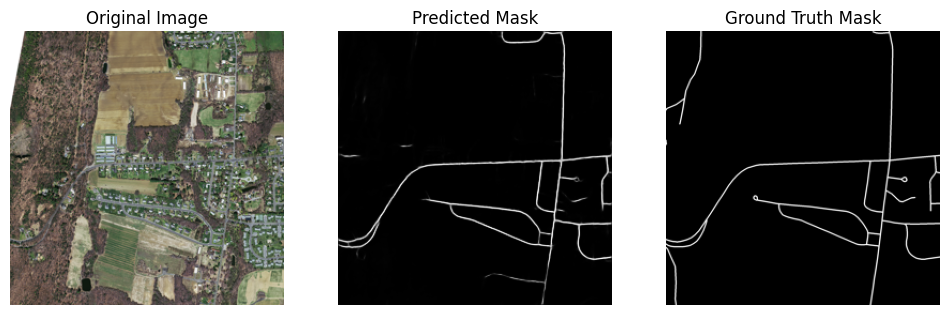

In [49]:
def predict_and_visualize(model, image_path, mask_path=None):
    image = Image.open(image_path).resize((256, 256))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the mask using the trained model
    predicted_mask = model.predict(image)
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    # Ensure the predicted mask is 2D
    if len(predicted_mask.shape) > 2:
        predicted_mask = np.squeeze(predicted_mask, axis=-1)  # Remove channel dimension if present

    # Visualize the original image, predicted mask, and the ground truth mask (if available)
    plt.figure(figsize=(12, 8))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0])  # Remove batch dimension
    plt.title("Original Image")
    plt.axis('off')

    # Plot predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    if mask_path:
        # Ground truth mask
        mask = Image.open(mask_path).resize((256, 256))
        mask = np.array(mask) / 255.0
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

    plt.show()

# Example usage after model training
test_image_path = "/content/local_tiff/train/10078690_15.tiff"  # Path to test image
test_mask_path = "/content/local_tiff/train_labels/10078690_15.tif"  # Path to corresponding ground truth mask
predict_and_visualize(model, test_image_path, test_mask_path)
